In [29]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import scipy
import numpy as np 
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import linear_sum_assignment
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from glob import glob
from albumentations.pytorch import ToTensorV2
from utils.sort_filename import natural_keys
from utils.visualize import show_landmark
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Visualize dataset

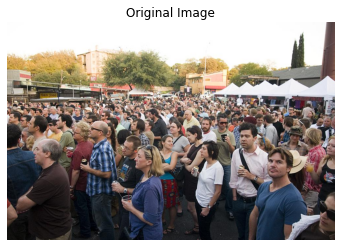

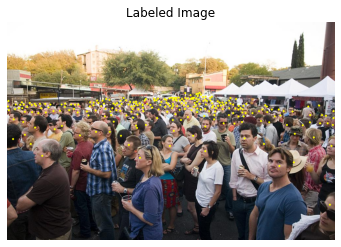

In [2]:
df = pd.read_csv("data/ShanghaiTech/part_A/train_data/data.csv")
idx = 2
img = cv2.cvtColor(cv2.imread(df['image'].iloc[idx]), cv2.COLOR_BGR2RGB)
label = loadmat(df['label'].iloc[idx])['image_info'][0][0][0][0][0].astype(int)

plt.title("Original Image")
plt.imshow(img)
plt.axis(False)
plt.show()

### Put Landmark on the image
circle_option = {'radius':3, 'color':(255, 255, 0), 'thickness':-1}
new_img = show_landmark(img, label, circle_option)
plt.title("Labeled Image")
plt.imshow(new_img)
plt.axis(False)
plt.show()

# Generate density map from point labeled

In [3]:
def generate_density_map(dim, label, k=1, threshold=3):
  '''
    dim : tuple of image shape (not include channels)
    label : list or numpy array of landmark
    k : smoothness of gaussian
    threshold : maximum l2 distance for sigma
  '''
  label = np.array(label, dtype=int) ## if label is list, convert to numpy
  if label.shape[0] == 0 : ## there are no landmark in the images
    return np.zeros(dim, dtype=np.float32)

  sigma_pow = 0  
  if k is not None:
    sigma_pow = 1/k
  
  if label.shape[0] == 1: ## If there are only 1 landmark, than sigma is equal to threshold
    sigma = np.array([threshold])
  else: ## else, sigma is equal to l2 distance of the nearest neigbor
    dist = (((np.expand_dims(label, 0) - np.expand_dims(label, 1)) ** 2).sum(axis=-1)**0.5)
    min_idx = dist.argsort(axis=1)[:, 1]
    sigma = dist[np.arange(dist.shape[0]), min_idx]

  density = np.zeros(dim, dtype=np.float32)
  for i, point in enumerate(label):
    local =  np.zeros(dim, dtype=np.float32)
    local[point[1], point[0]] = 1
    if sigma_pow == 0:
      density += local
    else:
      density += scipy.ndimage.filters.gaussian_filter(local, min(sigma[i], threshold)**sigma_pow, mode='constant')
  return density

In [4]:
def reshape_split(image, kernel_size): ## make grid for image
  img_height, img_width, channels = image.shape
  tile_height, tile_width = kernel_size

  tiled_array = image.reshape(img_height // tile_height,
                              tile_height, 
                              img_width // tile_width,
                              tile_width,
                              channels)
  tiled_array = tiled_array.swapaxes(1, 2)
  return tiled_array

In [5]:
class ShanghaiTech(Dataset):
  def __init__(self, df_path, transform=None, num_queries=500):
    self.df = pd.read_csv(df_path)
    self.transform = transform
    self.num_queries = num_queries
    self.load_images(self.df)
  
  def load_images(self, df):
    self.images = df['image'].apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB))
    self.labels = df['label'].apply(lambda x: loadmat(x)['image_info'][0][0][0][0][0]) ## !!! forget to normalize position to [0, 1]

  def __len__(self):
    return len(self.df)-1
  
  def __getitem__(self, idx):
    assert idx < len(self.images), "Index out of range"
    img = self.images[idx]
    label = self.labels[idx].astype(int)

    if self.transform:
      transformed = self.transform(image=img, keypoints=label)
      img, label = transformed['image'], transformed['keypoints'] ## !!!! concern need to flip label if image is flip

    # density_map = np.array([generate_density_map(img.shape[1:], label, 1), generate_density_map(img.shape[1:], label, 2), generate_density_map(img.shape[1:], label, None)])
    label_density = np.array(label)
    if label_density.shape[0] != 0:
      label_density = np.array(label) / img.shape[1:] * 28
    density_map = np.array([generate_density_map((28, 28),label_density, 1), generate_density_map((28, 28), label_density, 2), generate_density_map((28, 28), label_density, None)])
    mask_label = torch.zeros(self.num_queries, dtype=bool)
    mask_label[:len(label)] = True
    label = torch.FloatTensor(label).reshape((-1, 2)) / torch.FloatTensor([[img.shape[1], img.shape[2]]])
    pad = (0, 0, 0, self.num_queries - len(label))
    label = F.pad(label, pad, mode='constant', value=-1)

    return img, label, mask_label, density_map

In [6]:
class ShanghaiTechTest(Dataset):
  def __init__(self, df_path, transform=None, num_queries=500):
    self.df = pd.read_csv(df_path)
    self.transform = transform
    self.num_queries = num_queries
    self.load_images(self.df)
  
  def load_images(self, df):
    self.images = df['image'].apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB))
    self.labels = df['label'].apply(lambda x: loadmat(x)['image_info'][0][0][0][0][0]) ## !!! forget to normalize position to [0, 1]

  def __len__(self):
    return len(self.df)-1
  
  def __getitem__(self, idx):
    assert idx < len(self.images), "Index out of range"
    img = self.images[idx]
    label_gt = self.labels[idx].astype(int)
    ## Padding Image for gridding
    img_pad = cv2.copyMakeBorder(img, 0, 128 - (img.shape[0] % 128), 0, 128 - (img.shape[1] % 128), cv2.BORDER_CONSTANT, (0,0,0))
    grid_img = reshape_split(img_pad, (128, 128))

    yv, xv = np.meshgrid(np.arange(img_pad.shape[1]+1, step=128), np.arange(img_pad.shape[0]+1, step=128))

    batch_img = torch.empty((0, 3, 224, 224), dtype=torch.float32)
    batch_label = torch.empty((0, 500, 2), dtype=torch.float32)
    batch_mask_label = torch.empty((0, 500), dtype=torch.float32)
    batch_density_map = torch.empty((0, 3, 28, 28), dtype=torch.float32)

    for row in range(grid_img.shape[0]):
      for col in range(grid_img.shape[1]):
        x_start, x_stop = xv[row, col], xv[row+1, col+1]
        y_start, y_stop = yv[row, col], yv[row+1, col+1]

        check_x = (x_start <= label_gt[:, 1]) & (label_gt[:, 1] < x_stop)
        check_y = (y_start <= label_gt[:, 0]) & (label_gt[:, 0] < y_stop)
        valid_idx = check_x & check_y
        label = label_gt[valid_idx] - np.array([[y_start, x_start]])

        if self.transform:
          transformed = self.transform(image=grid_img[row, col], keypoints=label)
          img, label = transformed['image'], transformed['keypoints'] ## !!!! concern need to flip label if image is flip

        # density_map = np.array([generate_density_map(img.shape[1:], label, 1), generate_density_map(img.shape[1:], label, 2), generate_density_map(img.shape[1:], label, None)])
        label_density = np.array(label)
        if label_density.shape[0] != 0:
          label_density = np.array(label) / img.shape[1:] * 28
        density_map = np.array([generate_density_map((28, 28),label_density, 1), generate_density_map((28, 28), label_density, 2), generate_density_map((28, 28), label_density, None)])
        density_map = torch.FloatTensor(density_map)
        mask_label = torch.zeros(self.num_queries, dtype=bool)
        mask_label[:len(label)] = True
        label = torch.FloatTensor(label).reshape((-1, 2)) / torch.FloatTensor([[img.shape[1], img.shape[2]]])
        pad = (0, 0, 0, self.num_queries - len(label))
        label = F.pad(label, pad, mode='constant', value=-1)
        
        batch_img = torch.cat((batch_img, img.unsqueeze(0)))
        batch_label = torch.cat((batch_label, label.unsqueeze(0)))
        batch_mask_label = torch.cat((batch_mask_label, mask_label.unsqueeze(0)))
        batch_density_map = torch.cat((batch_density_map, density_map.unsqueeze(0)))

    return batch_img, batch_label, batch_mask_label, batch_density_map, grid_img.shape[:2]

In [7]:
transform = A.Compose([
  A.RandomCrop(128, 128),
  A.Resize(224, 224),
  A.HorizontalFlip(p=0.5),
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy'))

train_dataset = ShanghaiTech('data/ShanghaiTech/part_A/train_data/data.csv', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)


transform = A.Compose([
  A.Resize(224, 224),
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy'))

test_dataset = ShanghaiTechTest('data/ShanghaiTech/part_A/test_data/data.csv', transform=transform)

# Verify Dataset & DataLoader

In [8]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalizer = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Test set

In [9]:
batch_img, batch_label, batch_mask_label, batch_density_map, grid_shape = test_dataset[2]

In [ ]:
for idx, data in enumerate(test_dataset):
  batch_img, batch_label, batch_mask_label, batch_density_map, grid_shape = data
  batch_img = batch_img.reshape((grid_shape[0], grid_shape[1], 3, 224, 224))
  batch_label = batch_label.reshape((grid_shape[0], grid_shape[1], 500, 2))
  fig, ax = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1])
  for row in range(grid_shape[0]):
    for col in range(grid_shape[1]):
      img = batch_img[row, col]
      unnorm_img = unnormalizer(img)
      unnorm_img = img.permute(1, 2, 0).numpy().copy()
      new_img = show_landmark(unnorm_img, batch_label[row, col] * torch.FloatTensor([[img.shape[1], img.shape[2]]]))
      ax[row][col].imshow(new_img)
      ax[row][col].axis(False)

  plt.show()

In [41]:
print(len(test_dataset))

181


In [44]:
for idx in range(len(test_dataset)):
  batch_img, batch_label, batch_mask_label, batch_density_map, grid_shape = test_dataset[idx]
  print("Img", batch_img.shape)
  print("label", batch_label.shape)
  print("mask label", batch_mask_label.shape)
  print("Density Map:", batch_density_map.shape)
  print()
  continue

Img torch.Size([54, 3, 224, 224])
label torch.Size([54, 500, 2])
mask label torch.Size([54, 500])
Density Map: torch.Size([54, 3, 28, 28])

Img torch.Size([54, 3, 224, 224])
label torch.Size([54, 500, 2])
mask label torch.Size([54, 500])
Density Map: torch.Size([54, 3, 28, 28])

Img torch.Size([24, 3, 224, 224])
label torch.Size([24, 500, 2])
mask label torch.Size([24, 500])
Density Map: torch.Size([24, 3, 28, 28])

Img torch.Size([12, 3, 224, 224])
label torch.Size([12, 500, 2])
mask label torch.Size([12, 500])
Density Map: torch.Size([12, 3, 28, 28])

Img torch.Size([63, 3, 224, 224])
label torch.Size([63, 500, 2])
mask label torch.Size([63, 500])
Density Map: torch.Size([63, 3, 28, 28])

Img torch.Size([54, 3, 224, 224])
label torch.Size([54, 500, 2])
mask label torch.Size([54, 500])
Density Map: torch.Size([54, 3, 28, 28])

Img torch.Size([54, 3, 224, 224])
label torch.Size([54, 500, 2])
mask label torch.Size([54, 500])
Density Map: torch.Size([54, 3, 28, 28])

Img torch.Size([54, 

# Train set

In [18]:
for data in train_dataloader:
  img, label, mask_label, density_map = data
  print("Img", img.shape)
  print("label", label.shape)
  print("mask label", mask_label.shape)
  print("Density Map:", density_map.shape)
  break

Img torch.Size([16, 3, 224, 224])
label torch.Size([16, 500, 2])
mask label torch.Size([16, 500])
Density Map: torch.Size([16, 3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of People in a Image: tensor(10)


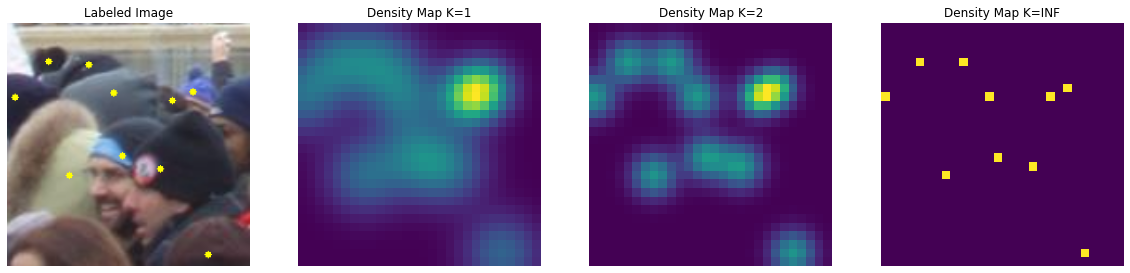

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 9.007131
Estimate Count: 9.409291
Estimate Count: 10.0
Number of People in a Image: tensor(11)


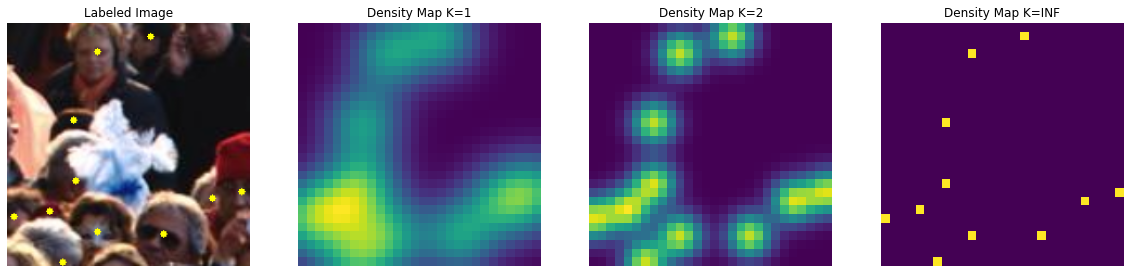

Estimate Count: 8.837015
Estimate Count: 9.58609
Estimate Count: 11.0
Number of People in a Image: tensor(0)


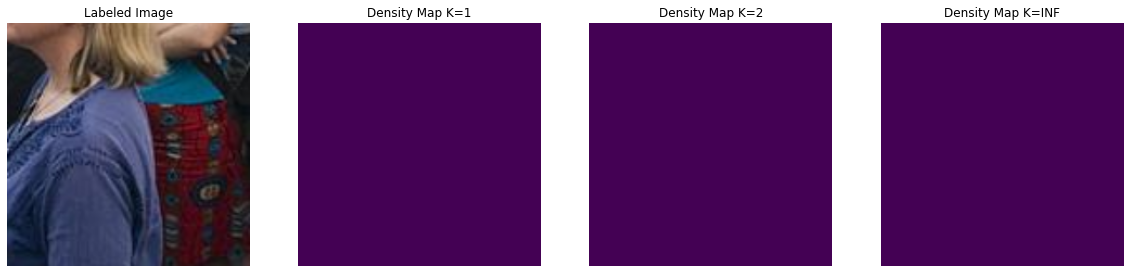

Estimate Count: 0.0
Estimate Count: 0.0
Estimate Count: 0.0
Number of People in a Image: tensor(0)


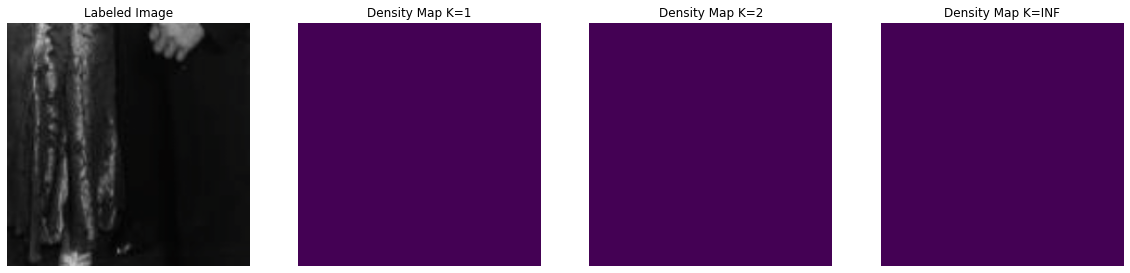

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 0.0
Estimate Count: 0.0
Estimate Count: 0.0
Number of People in a Image: tensor(49)


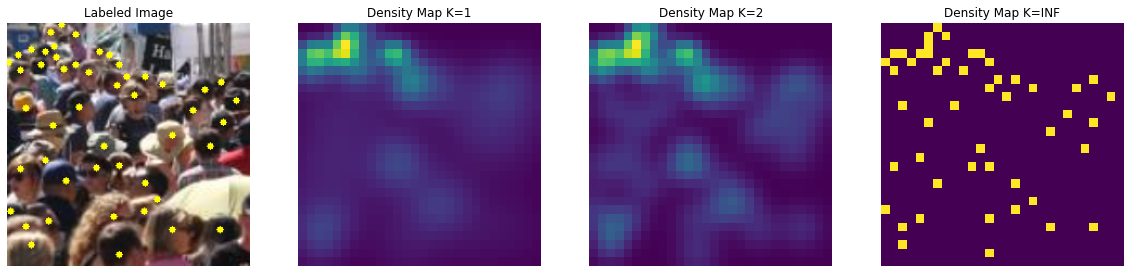

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 45.311165
Estimate Count: 46.82411
Estimate Count: 49.0
Number of People in a Image: tensor(1)


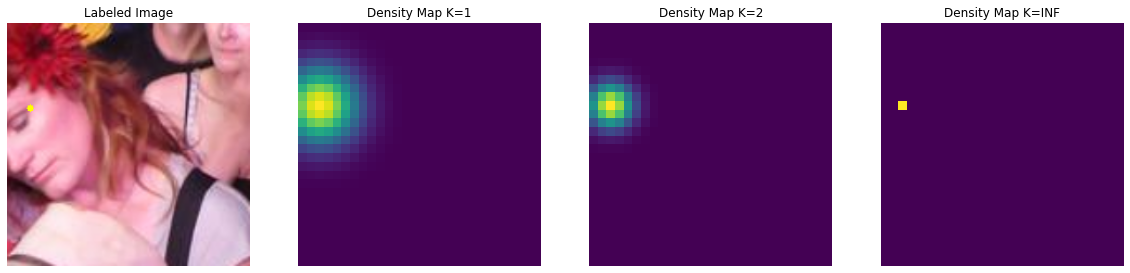

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 0.79820174
Estimate Count: 0.9283944
Estimate Count: 1.0
Number of People in a Image: tensor(3)


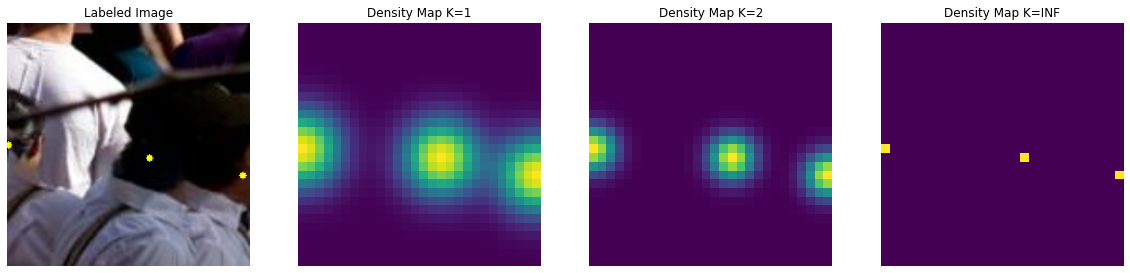

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 2.132824
Estimate Count: 2.2303321
Estimate Count: 3.0
Number of People in a Image: tensor(1)


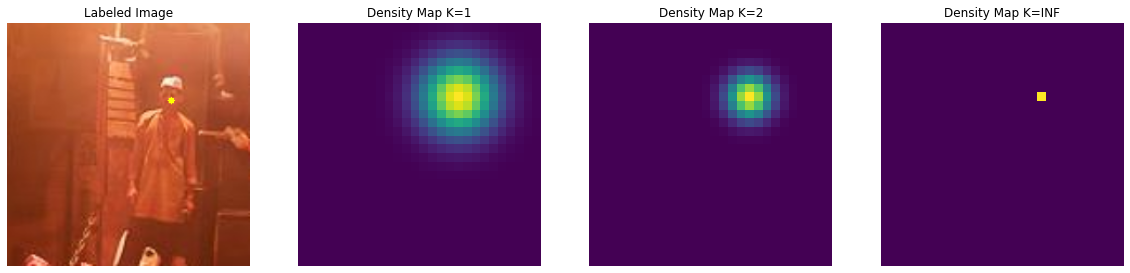

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 0.99708664
Estimate Count: 1.0000001
Estimate Count: 1.0
Number of People in a Image: tensor(1)


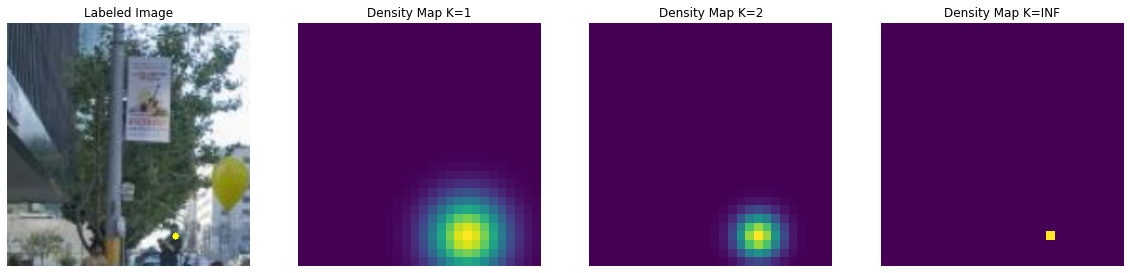

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 0.8775038
Estimate Count: 0.9797883
Estimate Count: 1.0
Number of People in a Image: tensor(2)


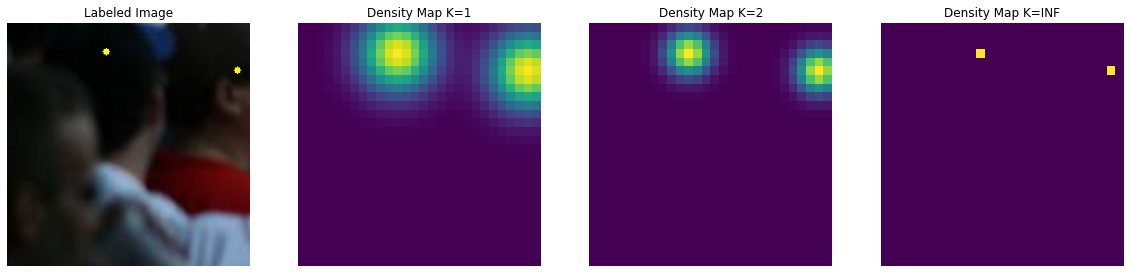

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimate Count: 1.5490252
Estimate Count: 1.7894108
Estimate Count: 2.0
Number of People in a Image: tensor(2)


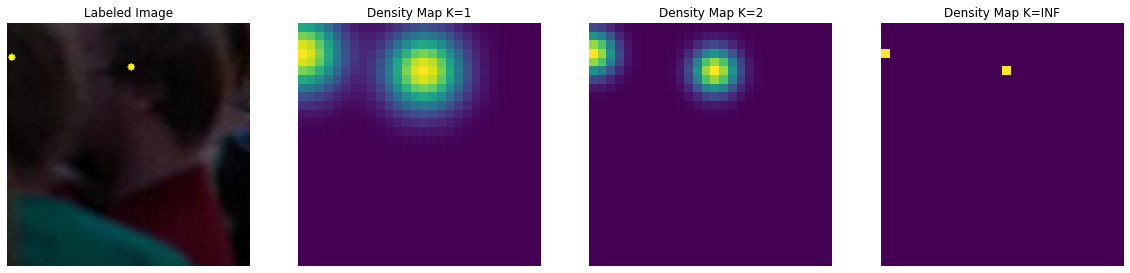

Estimate Count: 1.46546
Estimate Count: 1.6020962
Estimate Count: 2.0


In [9]:
n_img = 10
circle_option = {'radius':3, 'color':(255, 255, 0), 'thickness':-1}
for idx, data in enumerate(train_dataset):
  if idx > n_img:
    break
  img, label, mask_label, density_map = data
  print("Number of People in a Image:", mask_label.sum())
  unnorm_img = unnormalizer(img)
  new_img = show_landmark(unnorm_img.permute(1, 2, 0).numpy(), label * torch.FloatTensor([[img.shape[1], img.shape[2]]]), circle_option)

  fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
  ax[0].imshow(new_img)
  ax[0].axis(False)
  ax[0].set_title("Labeled Image")
  ax[1].imshow(density_map[0])
  ax[1].axis(False)
  ax[1].set_title("Density Map K=1")
  ax[2].imshow(density_map[1])
  ax[2].axis(False)
  ax[2].set_title("Density Map K=2")
  ax[3].imshow(density_map[2])
  ax[3].axis(False)
  ax[3].set_title("Density Map K=INF")
  plt.show()
  print("Estimate Count:", density_map[0].sum())
  print("Estimate Count:", density_map[1].sum())
  print("Estimate Count:", density_map[2].sum())

# Model

In [10]:
class BackBone(nn.Module):
  def __init__(self, name):
    super().__init__()
    self.backbone = getattr(torchvision.models, name)(pretrained=True)

    self.backbone = create_feature_extractor(
            self.backbone, return_nodes={"features.denseblock2": "denseblock2", "flatten": "featmap"})
    
    self.fc = nn.Sequential(
      nn.Linear(1920, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.ReLU()
    )
    for param in self.backbone.parameters():
      param.requires_grad = False
  
  def forward(self, x):
    x = self.backbone(x)
    db2, featmap = x["denseblock2"], x["featmap"]
    output = self.fc(featmap)
    return {"denseblock2": db2, "count": output}

In [11]:
class DenseLayer(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.norm1 = nn.BatchNorm2d(input_dim, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=(1, 1), stride=(1, 1), bias=False)
    self.norm2 = nn.BatchNorm2d(hidden_dim, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu2 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(hidden_dim, output_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

  def forward(self, x):
    x = self.relu1(self.norm1(x))
    x = self.conv1(x)
    x = self.relu2(self.norm2(x))
    x = self.conv2(x)
    return x

In [12]:
class DenseBlock(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    '''
      Density Layer: input dim = (513, 28, 28) output_dim = (513 + 32 * 4, 28, 28)
    '''
    super().__init__()
    self.dense1 = DenseLayer(input_dim, hidden_dim, output_dim)
    self.dense2 = DenseLayer(input_dim+output_dim, hidden_dim, output_dim) ## residual connection
    self.dense3 = DenseLayer(input_dim+2*output_dim, hidden_dim, output_dim)
    self.dense4 = DenseLayer(input_dim+3*output_dim, hidden_dim, output_dim)
  
  def forward(self, feat):
    feat1 = self.dense1(feat)
    feat2 = self.dense2(torch.cat([feat, feat1], dim=1))
    feat3 = self.dense3(torch.cat([feat, feat1, feat2], dim=1))
    feat4 = self.dense4(torch.cat([feat, feat1, feat2, feat3], dim=1))

    output = torch.cat([feat, feat1, feat2, feat3, feat4], dim=1)
    return output

In [13]:
class DensityNetwork(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.density1 = nn.Conv2d(input_dim, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    self.dense2 = DenseBlock(input_dim + 1, hidden_dim, output_dim)
    self.density2 = nn.Conv2d(input_dim + 1 + output_dim * 4, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    self.dense3 = DenseBlock(input_dim + 3 + output_dim * 4, hidden_dim, output_dim)
    self.density3 = nn.Conv2d(input_dim + 3 + output_dim * 8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  
  def forward(self, feat):
    # feat = F.upsample_bilinear(feat, size=(224, 224)) # add this line
    density_map1 = self.density1(feat)
    dense2 = self.dense2(torch.cat([feat, density_map1], dim=1))
    density_map2 = self.density2(dense2)
    dense3 = self.dense3(torch.cat([dense2, density_map1, density_map2], dim=1))
    density_map3 = self.density3(dense3)

    return {
      "level1": torch.abs(density_map1), 
      "level2": torch.abs(density_map2),
      "levelinf": torch.abs(density_map3)
    }

In [14]:
class DenseNetWithCompositionLoss(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, name):
    super().__init__()
    self.backbone = BackBone(name)
    self.density = DensityNetwork(input_dim, hidden_dim, output_dim)

  def forward(self, img):
    x = self.backbone(img)
    denseblock2, count = x['denseblock2'], x['count']
    density_map = self.density(denseblock2)

    return density_map, count

In [14]:
model = DenseNetWithCompositionLoss(512, 128, 32, 'densenet201')

In [15]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
DenseNetWithCompositionLoss                        --                        --
├─BackBone: 1-1                                    [32, 1]                   --
│    └─DenseNet: 2-1                               [32, 1920]                --
│    │    └─Module: 3-1                            --                        (18,092,928)
│    └─Sequential: 2-2                             [32, 1]                   --
│    │    └─Linear: 3-2                            [32, 128]                 245,888
│    │    └─ReLU: 3-3                              [32, 128]                 --
│    │    └─Linear: 3-4                            [32, 1]                   129
│    │    └─ReLU: 3-5                              [32, 1]                   --
├─DensityNetwork: 1-2                              [32, 1, 28, 28]           --
│    └─Conv2d: 2-3                                 [32, 1, 28, 28]           512
│    └─DenseBlock:

In [29]:
for data in train_dataloader:
  img, label, mask_label, density_map = data
  print("Img", img.shape)
  print("label", label.shape)
  print("mask label", mask_label.shape)
  print("Density Map:", density_map.shape)
  density_map, count = model(img.cuda())
  print(mask_label.sum(axis=1))
  print(count.shape)
  break

Img torch.Size([16, 3, 224, 224])
label torch.Size([16, 500, 2])
mask label torch.Size([16, 500])
Density Map: torch.Size([16, 3, 224, 224])
tensor([14,  4, 15,  0, 51, 28, 53,  3,  3, 65, 18, 15, 21, 24,  0,  1])
torch.Size([16, 1])


In [379]:
density_map, count = model(torch.ones((32, 3, 224, 224)).cuda())

In [380]:
density_map['level1'].shape

torch.Size([32, 1, 28, 28])

# Train

In [15]:
config = {
  "name": "densenet201",
  "input_dim": 512,
  "hidden_dim": 128,
  "output_dim": 32
}

model = DenseNetWithCompositionLoss(**config).cuda()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criteria = nn.MSELoss(reduction='mean')
scheduler = optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, verbose=True)

num_epochs = 70
total_train_loss = 0
total_test_loss = 0
train_losses = [] 
test_losses = []

min_loss = 1e6

Adjusting learning rate of group 0 to 1.0000e-03.


In [28]:
for epoch in range(num_epochs):
  total_train_loss = 0
  total_test_loss = 0
  model.train()
  for data in train_dataloader:
    img, label, mask_label, density_map_gt = data
    density_map_predicted, count = model(img.cuda())
    gt_count = mask_label.sum(axis=1, keepdim=True, dtype=torch.float32).cuda()

    # d_map1 = F.interpolate(density_map_predicted['level1'], size=(224, 224), mode='bilinear')
    # d_map2 = F.interpolate(density_map_predicted['level2'], size=(224, 224), mode='bilinear')
    # d_mapinf = F.interpolate(density_map_predicted['levelinf'], size=(224, 224), mode='bilinear')
    d_map1 = density_map_predicted['level1']
    d_map2 = density_map_predicted['level2']
    d_mapinf = density_map_predicted['levelinf']

    mean_count = (d_map1.flatten(1).sum(dim=1, keepdims=True) + d_map2.flatten(1).sum(dim=1, keepdims=True) + d_mapinf.flatten(1).sum(dim=1, keepdims=True) + count) / 4
    reg_loss = criteria(mean_count, gt_count) # criteria(count, gt_count) 

    l1_loss = criteria(d_map1, density_map_gt[:, 0:1].cuda())
    l2_loss = criteria(d_map2, density_map_gt[:, 1:2].cuda())
    linf_loss = criteria(d_mapinf, density_map_gt[:, 2:3].cuda())

    loss = 1 * reg_loss + 100 * l1_loss + 1000 * l2_loss + 2000 * linf_loss + 2 * criteria(count, gt_count)
    # loss = 0.01 * reg_loss + 1 * l1_loss + 10 * l2_loss + 100 * linf_loss + criteria(count, gt_count)
    # loss = reg_loss
    # loss = criteria(count, gt_count)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_train_loss += loss.cpu().detach().numpy()

  # Validate
  model.eval()
  len_test = 0
  for idx in range(len(test_dataset)):
    img, label, mask_label, density_map_gt, grid_shape = test_dataset[idx]
    len_test += grid_shape[0] * grid_shape[1]
    density_map_predicted, count = model(img.cuda())
    gt_count = mask_label.sum(axis=1, keepdim=True, dtype=torch.float32).cuda()

    d_map1 = density_map_predicted['level1']
    d_map2 = density_map_predicted['level2']
    d_mapinf = density_map_predicted['levelinf']

    mean_count = (d_map1.flatten(1).sum(dim=1, keepdims=True) + d_map2.flatten(1).sum(dim=1, keepdims=True) + d_mapinf.flatten(1).sum(dim=1, keepdims=True) + count) / 4
    reg_loss = criteria(mean_count, gt_count) # criteria(count, gt_count) 

    l1_loss = criteria(d_map1, density_map_gt[:, 0:1].cuda())
    l2_loss = criteria(d_map2, density_map_gt[:, 1:2].cuda())
    linf_loss = criteria(d_mapinf, density_map_gt[:, 2:3].cuda())

    loss = 1 * reg_loss + 100 * l1_loss + 1000 * l2_loss + 2000 * linf_loss + 2 * criteria(count, gt_count)
    total_test_loss += loss.cpu().detach().numpy()

  current_train_loss = total_train_loss / len(train_dataloader)
  current_test_loss = total_test_loss / len(test_dataset)
  scheduler.step()
  train_losses.append(current_train_loss)
  test_losses.append(current_test_loss)
  print("Epoch:", epoch, "Train Loss:", current_train_loss, "Test Loss:", current_test_loss)
  print()

  if current_test_loss < min_loss:
    min_loss = current_test_loss
    print("Save Best Model ...")
    torch.save(model.state_dict(), "best_composition_loss.pth")

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0 Train Loss: 36258.2234400699 Test Loss: 2853.6428701495597

Save Best Model ...
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 1 Train Loss: 5671.738775956003 Test Loss: 1739.8773227923482

Save Best Model ...
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 2 Train Loss: 3442.367939196135 Test Loss: 1828.0457874951442

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 3 Train Loss: 2905.227211400082 Test Loss: 1652.088542453492

Save Best Model ...
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 4 Train Loss: 3435.8506244860196 Test Loss: 1532.3378365026654

Save Best Model ...
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 5 Train Loss: 3091.968804610403 Test Loss: 1536.7684026054255

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 6 Train Loss: 2849.888437371505 Test Loss: 1638.6231052124697

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 7 Train Loss: 3319.31845

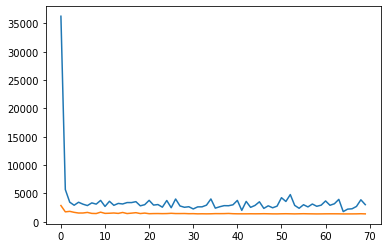

In [30]:
plt.plot(np.arange(70), train_losses)
plt.plot(np.arange(70), test_losses)

In [16]:
best_weights_path = 'best_composition_loss.pth' 
model.cuda()
model.load_state_dict(torch.load(best_weights_path))
model.eval()

DenseNetWithCompositionLoss(
  (backbone): BackBone(
    (backbone): DenseNet(
      (features): Module(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): Module(
          (denselayer1): Module(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): Module(


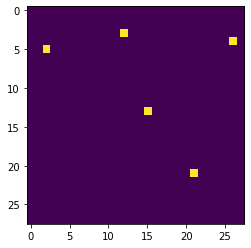

In [46]:
plt.imshow(density_map_gt[19, 2])

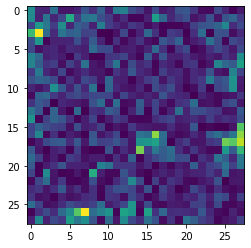

In [48]:
plt.imshow(density_map_predicted['levelinf'][19, 0].detach().cpu().numpy())

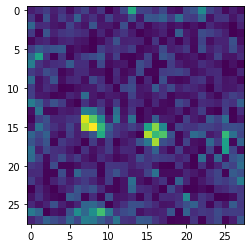

In [45]:
plt.imshow(density_map_predicted['levelinf'][1, 0].detach().cpu().numpy())

# Evaluate

In [16]:
best_weights_path = 'best_composition_loss.pth' 
model.cuda()
model.load_state_dict(torch.load(best_weights_path))
model.eval()

DenseNetWithCompositionLoss(
  (backbone): BackBone(
    (backbone): DenseNet(
      (features): Module(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): Module(
          (denselayer1): Module(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): Module(


## Counting

In [71]:
mean_counts = []
gt_counts = []
for idx in range(len(test_dataset)):
  img, label, mask_label, density_map_gt, grid_shape = test_dataset[idx]
  density_map_predicted, count = model(img.cuda())
  gt_count = mask_label.sum(axis=1, keepdim=True, dtype=torch.float32).cuda()

  d_map1 = density_map_predicted['level1']
  d_map2 = density_map_predicted['level2']
  d_mapinf = density_map_predicted['levelinf']

  mean_count = (d_map1.flatten(1).sum(dim=1, keepdims=True) + d_map2.flatten(1).sum(dim=1, keepdims=True) + d_mapinf.flatten(1).sum(dim=1, keepdims=True) + count) / 4
  mean_counts.append(mean_count.sum().cpu().detach().numpy())
  gt_counts.append(gt_count.sum().cpu().detach().numpy())
  

In [74]:
mean_counts = np.concatenate(mean_counts)
gt_counts = np.concatenate(gt_counts)

TypeError: The first input argument needs to be a sequence

In [75]:
mean_counts = torch.FloatTensor(np.array(mean_counts))
gt_counts = torch.FloatTensor(np.array(gt_counts))

In [77]:
criteria(mean_counts, gt_counts) ** 0.5

tensor(242.3141)

In [33]:
mean_counts.shape

torch.Size([7222, 1])

In [78]:
(np.abs(mean_counts - gt_counts)).sum() / mean_counts.shape[0]

tensor(194.5875)

## Localization

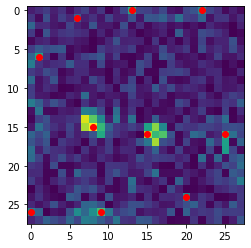

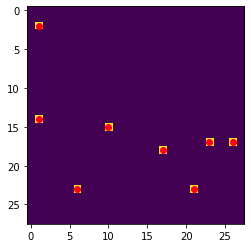

In [24]:
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

def local_maximum(data, neighborhood_size=10, threshold=0.04):
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)

    x = np.expand_dims(np.array(x), 1)
    y = np.expand_dims(np.array(y), 1)
    return np.concatenate((x, y), axis=1)


idx = 1
data = density_map_predicted['levelinf'][idx, 0].cpu().detach().numpy()
pred_points = local_maximum(data)

plt.imshow(data)
plt.plot(pred_points[:, 0], pred_points[:, 1], 'ro')
plt.show()

plt.imshow(density_map_gt[idx, 2])
plt.plot((label[idx] * 28)[mask_label[idx].bool()].floor()[:, 0], (label[idx] * 28)[mask_label[idx].bool()].floor()[:, 1], 'ro')
plt.show()

In [25]:
circle_option = {'radius':10, 'color':(255, 255, 0), 'thickness':-1}
pred_localization = []
gt_localization = []

for idx in tqdm(range(len(test_dataset))):
  img, label, mask_label, density_map_gt, grid_shape = test_dataset[idx]
  density_map_predicted, count = model(img.cuda())
  gt_count = mask_label.sum(axis=1, keepdim=True, dtype=torch.float32).cuda()

  d_mapinf = density_map_predicted['levelinf'].reshape((grid_shape[0], grid_shape[1], 1, 28, 28))

  img = img.reshape((grid_shape[0], grid_shape[1], 3, 224, 224))
  label = label.reshape((grid_shape[0], grid_shape[1], 500, 2))
  mask_label = mask_label.reshape((grid_shape[0], grid_shape[1], 500))
  # fig, ax = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(20, 20))
  
  pred_point_img = []
  gt_point_img = []

  for row in range(grid_shape[0]):
    for col in range(grid_shape[1]):
      x_start, x_stop = 128 * row, 128 * (row+1)
      y_start, y_stop = 128 * col, 128 * (col+1)

      data = d_mapinf[row, col, 0].cpu().detach().numpy()
      pred_points = local_maximum(data, neighborhood_size=5, threshold=0.07) / np.array([28, 28]) * np.array([128, 128]) + np.array([y_start, x_start])
      gt_label = label[row, col, mask_label[row, col].bool()] * np.array([128, 128]) + np.array([y_start, x_start])
      # gt_label = label[row, col, mask_label[row, col].bool()]

      pred_point_img.append(pred_points)
      gt_point_img.append(gt_label)

      # new_img = show_landmark(img[row, col].permute(1, 2, 0).numpy().copy(), label[row, col, mask_label[row, col].bool()] * np.array([224, 224]), circle_option)
      # ax[row][col].imshow(new_img)
      # ax[row][col].axis(False)

  pred_point_img = np.concatenate(pred_point_img)
  gt_point_img = np.concatenate(gt_point_img)
  pred_localization.append(pred_point_img)
  gt_localization.append(gt_point_img)
  # plt.show()

100%|██████████| 181/181 [01:22<00:00,  2.20it/s]


In [30]:
len_test = len(pred_localization)
threshold = 1


thresholds = [10]
precision = []
recall = []
f1 = []

for threshold in tqdm(thresholds):
  pred_class = []
  gt_class = []
  for pred, gt in zip(pred_localization, gt_localization):
      diff = ((np.expand_dims(pred, axis=0) - np.expand_dims(gt, axis=1))**2).sum(axis=-1)**0.5
      gt_ind, pred_ind = linear_sum_assignment(diff)
      cost = diff[gt_ind, pred_ind]
      
      pred_class.append(np.ones((cost < threshold).sum()))
      gt_class.append(np.ones((cost < threshold).sum()))

      pred_class.append(np.ones((cost >= threshold).sum()))
      gt_class.append(np.zeros((cost >= threshold).sum()))
      pred_class.append(np.zeros((cost >= threshold).sum()))
      gt_class.append(np.ones((cost >= threshold).sum()))

      if pred.shape[0] < gt.shape[0]:
        gt_class.append(np.ones(gt.shape[0] - pred.shape[0]))
        pred_class.append(np.zeros(gt.shape[0] - pred.shape[0]))
      else:
        gt_class.append(np.zeros(pred.shape[0] - gt.shape[0]))
        pred_class.append(np.ones(pred.shape[0] - gt.shape[0]))

  gt_class = np.concatenate(gt_class)
  pred_class = np.concatenate(pred_class)

  precision.append(precision_score(gt_class, pred_class))
  recall.append(recall_score(gt_class, pred_class))
  f1.append(f1_score(gt_class, pred_class))

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


In [32]:
localization_score = np.array(list(zip(precision, recall, f1))).mean(axis=0)

print("Average Precision Score:", localization_score[0])
print("Average Recall Score:", localization_score[1])
print("Average F1 Score:", localization_score[2])

Average Precision Score: 0.36569729270459195
Average Recall Score: 0.2407485094644242
Average F1 Score: 0.2903510184056604


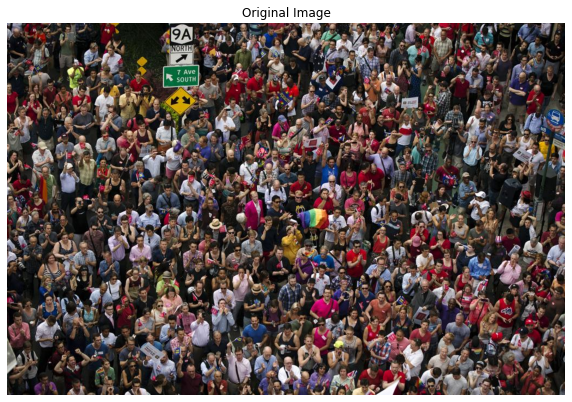

In [67]:
df = pd.read_csv("data/ShanghaiTech/part_A/test_data/data.csv")
idx = 19
img = cv2.cvtColor(cv2.imread(df['image'].iloc[idx]), cv2.COLOR_BGR2RGB)
img_pad = cv2.copyMakeBorder(img, 0, 128 - (img.shape[0] % 128), 0, 128 - (img.shape[1] % 128), cv2.BORDER_CONSTANT, (0,0,0))
label = loadmat(df['label'].iloc[idx])['image_info'][0][0][0][0][0].astype(int)

plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(img_pad[:img.shape[0], :img.shape[1]])
plt.axis(False)
plt.show()

### Put Landmark on the image
# circle_option = {'radius':10, 'color':(255, 255, 0), 'thickness':2}
# new_img = show_landmark(img_pad, pred_localization[idx], circle_option)
# circle_option = {'radius':3, 'color':(255, 0, 0), 'thickness':-1}
# new_img = show_landmark(img_pad, gt_localization[idx], circle_option)
# plt.figure(figsize=(10, 10))
# plt.title("Labeled Image")
# plt.imshow(new_img[:img.shape[0], :img.shape[1]])
# plt.axis(False)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 12)
# plt.show()

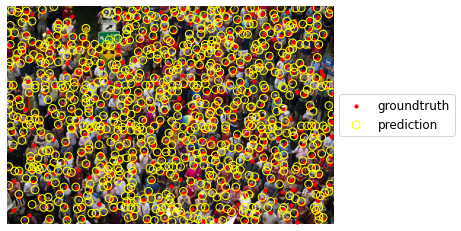

In [68]:
plt.imshow(img_pad[:img.shape[0], :img.shape[1]])
plt.scatter(gt_localization[idx][:, 0], gt_localization[idx][:, 1], s = 10, color = 'red', label = 'groundtruth')

#plot pred points
plt.scatter(pred_localization[idx][:, 0], pred_localization[idx][:, 1], s = 60, color = 'yellow', facecolors = 'none', label = 'prediction')

# plt.title(title, fontsize = 14)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 12)
plt.axis(False)
plt.show()

In [69]:
gt_localization[idx].shape

(460, 2)

In [70]:
pred_localization[idx].shape

(746, 2)